# Support Vector Regression (SVR) Model for Deconvolution of Human Immune Cell Types
### Non-Negative Least Squate Problem  
       
       I downloaded RNA-Seq data of the 29 immune cell types from https://www.ncbi.nlm.nih.gov/ with the accession number GEO: GSE107011. Data set is an 58311 x 127 dimensional matrix with expression of genes for sample cell types. We get the PBMC values for each sample to generate mixture data, and we find avearge gene expression values for same cell types to generate signature matrix. 
       Since each sample have different gene expression values, I applied min-max normalization method to mixture and signature data.
       After that, I calculate the standard deviation of each gene across cell type in the signature matrix, and  see that many of the gene have similar low variance while some of them have higher variance. Thus, we choose a treshold to generate signature matrix with highest variance genes.
       Then, I used SVR model to find the proportion matrix. Since the proportion values should be non-negative and sum of the proportion values for each sample should be one, I made the negative values zero, and normalized to sum up 1.
       

    
    



In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from sklearn.svm import NuSVR
from sklearn.metrics import r2_score
#read the data 
data =pd.read_csv('CHALLENGE DATA.csv')
#set gene names as index
data=data.set_index('Unnamed: 0')
data.head()


,DZQV_CD8_naive,DZQV_CD8_CM,DZQV_CD8_EM,DZQV_CD8_TE,DZQV_MAIT,DZQV_VD2+,DZQV_VD2-,DZQV_TFH,DZQV_Treg,DZQV_Th1,...,G4YW_mDC,G4YW_Neutrophils,G4YW_Basophils,DZQV_PBMC,925L_PBMC,9JD4_PBMC,G4YW_PBMC,4DUY_PBMC,36TS_PBMC,CR3L_PBMC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.214321,0.00000,0.004214,0.009533,0.011217,0.024504,0.00000,0.00000,0.66669,0.00000,...,0.00000,0.248643,0.00000,2.10965,3.83105,7.432370,3.871090,5.86248,6.943370,1.62892
ENSG00000227232.5,4.759630,3.49280,2.648770,3.722320,2.479270,4.188250,3.59954,5.08058,3.20052,8.44928,...,4.65285,1.538540,4.96184,2.06720,3.21687,0.343774,0.783651,0.00000,0.589092,3.02095
ENSG00000278267.1,0.000000,2.61518,2.459760,0.000000,4.586100,0.000000,0.00000,0.00000,0.00000,0.00000,...,1.67461,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,1.85684,0.000000,0.00000
ENSG00000243485.5,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000
ENSG00000284332.1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000


In [2]:
data.shape

(58311, 127)

In [3]:
#get the PBMC values for each sample to generate mixture data
mixture_data=data.loc[:, data.columns.str.contains('PBMC')]
mixture_data=mixture_data.fillna(0)
mixture_data.head()

,CYFZ_PBMC,FY2H_PBMC,FLWA_PBMC,453W_PBMC,684C_PBMC,CZJE_PBMC,DZQV_PBMC,925L_PBMC,9JD4_PBMC,G4YW_PBMC,4DUY_PBMC,36TS_PBMC,CR3L_PBMC
Unnamed: 0,,,,,,,,,,,,,
ENSG00000223972.5,3.01149,2.54756,1.86471,2.01926,1.05433,2.65111,2.10965,3.83105,7.432370,3.871090,5.86248,6.943370,1.62892
ENSG00000227232.5,2.62153,4.85206,2.78854,3.83599,2.34941,2.78231,2.06720,3.21687,0.343774,0.783651,0.00000,0.589092,3.02095
ENSG00000278267.1,0.00000,0.00000,0.00000,0.00000,2.81535,0.00000,0.00000,0.00000,0.000000,0.000000,1.85684,0.000000,0.00000
ENSG00000243485.5,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000
ENSG00000284332.1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000


In [4]:
mixture_data.shape

(58311, 13)

In [5]:
#generate signature matrix
#drop the PMBC values
signature = data.drop(data.filter(regex='PBMC').columns, axis=1)
# find avearge gene expression values for same cell types
# then create new columns for avearge value of  cell types  

signature['CD8_naive']=signature.loc[:, signature.columns.str.contains('CD8_naive')].mean(axis=1)

signature['CD8_CM']=signature.loc[:, signature.columns.str.contains('CD8_CM')].mean(axis=1)

signature['CD8_EM']=signature.loc[:, signature.columns.str.contains('CD8_EM')].mean(axis=1)

signature['CD8_TE']=signature.loc[:, signature.columns.str.contains('CD8_TE')].mean(axis=1)

signature['MAIT']=signature.loc[:, signature.columns.str.contains('MAIT')].mean(axis=1)

signature['VD2+']=signature.loc[:, signature.columns.str.contains('VD2+')].mean(axis=1)

signature['VD2-']=signature.loc[:, signature.columns.str.contains('VD2-')].mean(axis=1)

signature['TFH']=signature.loc[:, signature.columns.str.contains('TFH')].mean(axis=1)

signature['Treg']=signature.loc[:, signature.columns.str.contains('Treg')].mean(axis=1)

signature['Th1/Th17']=signature.loc[:, signature.columns.str.contains('Th1/Th17')].mean(axis=1)

signature['Th17']=signature.loc[:, signature.columns.str.contains('Th17')].mean(axis=1)

signature['Th2']=signature.loc[:, signature.columns.str.contains('Th2')].mean(axis=1)

signature['CD4_naive']=signature.loc[:, signature.columns.str.contains('CD4_naive')].mean(axis=1)

signature['Progenitor']=signature.loc[:, signature.columns.str.contains('Progenitor')].mean(axis=1)

signature['B_naive']=signature.loc[:, signature.columns.str.contains('B_naive')].mean(axis=1)

signature['B_NSM']=signature.loc[:, signature.columns.str.contains('B_NSM')].mean(axis=1)

signature['B_EX']=signature.loc[:, signature.columns.str.contains('B_EX')].mean(axis=1)

signature['B_SM']=signature.loc[:, signature.columns.str.contains('B_SM')].mean(axis=1)

signature['Plasmablasts']=signature.loc[:, signature.columns.str.contains('Plasmablasts')].mean(axis=1)

signature['C_mono']=signature.loc[:, signature.columns.str.contains('C_mono')].mean(axis=1)

signature['I_mono']=signature.loc[:, signature.columns.str.contains('I_mono')].mean(axis=1)

signature['NC_mono']=signature.loc[:, signature.columns.str.contains('NC_mono')].mean(axis=1)

signature['NK']=signature.loc[:, signature.columns.str.contains('NK')].mean(axis=1)

signature['pDC']=signature.loc[:, signature.columns.str.contains('pDC')].mean(axis=1)

signature['mDC']=signature.loc[:, signature.columns.str.contains('mDC')].mean(axis=1)

signature['Neutrophils']=signature.loc[:, signature.columns.str.contains('Neutrophils')].mean(axis=1)


signature['Basophils']=signature.loc[:, signature.columns.str.contains('Basophils')].mean(axis=1)

signature['CD4_TE']=signature.loc[:, signature.columns.str.contains('CD4_TE')].mean(axis=1)

# since there is another cell type name with Th1 we need to drop 'Th1/Th17' column first to choose only Th1 

Th1 = signature.drop(signature.filter(regex='Th1/Th17').columns, axis=1)
signature['Th1']=Th1.loc[:, Th1.columns.str.contains('Th1')].mean(axis=1)

#choose last 29 columns to take only cell type with avearge gene expression values
signature_matrix = signature[signature.columns[-29:]].copy()
signature_matrix=signature_matrix.fillna(0)
signature_matrix.head()

,CD8_naive,CD8_CM,CD8_EM,CD8_TE,MAIT,VD2+,VD2-,TFH,Treg,Th1/Th17,...,C_mono,I_mono,NC_mono,NK,pDC,mDC,Neutrophils,Basophils,CD4_TE,Th1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.203406,0.106600,0.287551,0.002920,0.002804,0.003280,0.000435,0.201344,0.227320,0.001728,...,0.118930,0.245839,0.000000,0.001171,0.226908,0.000000,0.219749,0.259817,0.000000,0.052075
ENSG00000227232.5,3.566488,3.805285,3.880703,3.420498,1.639900,3.187081,3.332605,3.315260,4.409733,3.184920,...,2.557758,0.963459,3.676425,2.805115,2.882265,3.030297,2.195975,2.731362,2.447345,4.507738
ENSG00000278267.1,0.531282,1.180673,1.077480,0.427700,1.618902,1.009516,1.238800,0.954052,2.439870,1.138515,...,0.238785,0.000000,0.477570,1.511792,0.475460,0.873107,0.508742,0.570323,0.000000,0.505495
ENSG00000243485.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000284332.1,0.000000,0.258200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.057947,0.000000,0.115893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
def normalization (df):
    'this is a min-max normalization method'
    
    Max_each_patient = df.max(axis=0)
    Min_each_patient=df.min(axis=0)
    Division=Max_each_patient-Min_each_patient 
    df_normalized = df.subtract(Min_each_patient, axis=1)
    df_normalized=df.divide(Division,axis=1)
    
    return df_normalized

In [5]:
#find normalized data sets
normalized_mixture=normalization(mixture_data)
normalized_signature=normalization(signature_matrix)
normalized_mixture=normalized_mixture.fillna(0)
normalized_mixture.head()

,CYFZ_PBMC,FY2H_PBMC,FLWA_PBMC,453W_PBMC,684C_PBMC,CZJE_PBMC,DZQV_PBMC,925L_PBMC,9JD4_PBMC,G4YW_PBMC,4DUY_PBMC,36TS_PBMC,CR3L_PBMC
Unnamed: 0,,,,,,,,,,,,,
ENSG00000223972.5,0.000076,0.000057,0.000064,0.000075,0.000029,0.000073,0.000062,0.000127,0.000214,0.000109,0.000200,0.000227,0.000050
ENSG00000227232.5,0.000066,0.000108,0.000095,0.000143,0.000065,0.000077,0.000061,0.000107,0.000010,0.000022,0.000000,0.000019,0.000093
ENSG00000278267.1,0.000000,0.000000,0.000000,0.000000,0.000077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000063,0.000000,0.000000
ENSG00000243485.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000284332.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
def Nu_SVR(mixture,signature):
    'main function to find the proportion matrix'
    "Support Vector Regression "
    
    cell_type_data=pd.DataFrame(columns=signature.columns.values.tolist())
    for column in mixture: 
        #support vector regression 
            regr_nusvr = NuSVR(kernel='linear')
            train_x=np.asanyarray(signature)
            train_y=np.asanyarray(mixture[column])
            model=regr_nusvr.fit (train_x, train_y)
            result=model.coef_
            #make the negative values zero, and normalized to sum up 1
            result=np.where(result<0, 0, result) 
            normalizer = 1 /  np.sum(result)
            estimated_cell_fraction= [x * normalizer for x in result]
            cell_type=pd.DataFrame(estimated_cell_fraction,index=[column],columns=signature.columns.values.tolist())
            cell_type_data=cell_type_data.append(cell_type)
    
    return cell_type_data

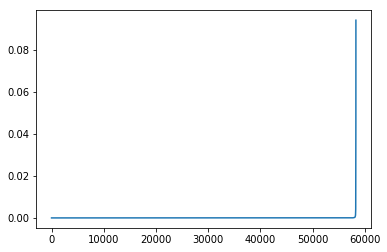

In [8]:
#find the variance of each genes of signature matrix and add a new coloum in the data frame

var_signature=normalized_signature.var(axis=1)
normalized_signature['Variance']=var_signature.values
plt.plot(sorted(var_signature))

In [9]:
def threshold_data_sets(mixture_data,signature_data_with_variance,threshold):
    
    ''' Before using this function, it is better to plot sorted_variance values to decide threshold.
    
     Signature matrix should include variance values
    
    
    '''

    threshold_signature = signature_data_with_variance[signature_data_with_variance['Variance']>=threshold]
    
    threshold_signature=threshold_signature.drop(['Variance'],axis=1)
    
    threshold_signature=threshold_signature.fillna(0)
    
    gene_signature=threshold_signature.index.values
    
    gene_mixture=normalized_mixture.index.values
    
    genes=[genes for genes in gene_mixture if genes not in gene_signature]
    
    threshold_mixture=mixture_data.drop(index=genes)
    threshold_mixture=threshold_mixture.fillna(0)
    
    return threshold_signature, threshold_mixture


In [10]:
def generate_test_data_score(samples,cell_type, gene, mixture_data,signature_matrix):
    '''
    This function gives the scores of randomly generated synthetic mixture data set
       
       sample:  number of samples for synthetic mixture data
       cell_type: # number cell_types
       gene: number of genes in the signature matrix
       mixture data:  threshold mixture data
       signature data : threshold signature matrix'''
    
    #generating synthetic mixture data 
    test_data=np.empty(shape=[samples,cell_type])
    test_mixture=np.empty(shape=[samples,gene])
    test_mixture_df=pd.DataFrame(index= mixture_data.index)
    result_test=pd.DataFrame(index=range(samples),columns=signature_matrix.columns.values.tolist())
    score_data=np.empty(shape=[samples,1])
    for i in range(samples):
        test_data[i]=np.array(np.random.random(cell_type))
        test_data[i] /=np.sum(test_data[i])
        test_mixture[i]=np.matmul(test_data[i],signature_matrix.T)
        test_mixture_df[i]=pd.DataFrame(test_mixture[i],index= mixture_data.index)
        test_mixture_df=test_mixture_df.fillna(0)
        #using synthetic mixture data in the model:
        result_test=Nu_SVR(test_mixture_df, signature_matrix)
        score_data[i]=r2_score(test_data[i],result_test.iloc[i])
    return score_data


In [11]:
''''an example of threshold_signature and threshold_mixture data'''

sample_signature,sample_mixture=threshold_data_sets(normalized_mixture,normalized_signature,6.144565610406107e-05)
sample_signature=sample_signature.T
#save the sample data tests
sample_signature.to_csv('sample_signature.csv') 
sample_mixture.to_csv('sample_mixture.csv') 

sample_signature.head()

Unnamed: 0,ENSG00000074800.13,ENSG00000142657.20,ENSG00000028137.18,ENSG00000142676.12,ENSG00000169442.8,ENSG00000198830.10,ENSG00000000938.12,ENSG00000130775.15,ENSG00000162511.7,ENSG00000182866.16,...,ENSG00000212907.2,ENSG00000198886.2,ENSG00000198786.2,ENSG00000198695.2,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2,ERCC-00002,ERCC-00074,ERCC-00096
CD8_naive,0.019306,0.001534,0.000521,0.029999,0.012729,0.016410,0.000091,0.000971,0.031175,0.030230,...,0.426865,0.245647,0.108467,0.075782,0.289643,0.006568,0.017030,0.083341,0.069839,0.053507
CD8_CM,0.019509,0.001310,0.002110,0.024920,0.016353,0.017403,0.000640,0.001060,0.034476,0.031658,...,0.297374,0.158015,0.089361,0.052855,0.232452,0.005435,0.010333,0.074055,0.067231,0.045749
CD8_EM,0.024111,0.001771,0.005592,0.011015,0.017618,0.023779,0.010812,0.001883,0.040473,0.041626,...,0.362777,0.206895,0.099897,0.086693,0.259394,0.008106,0.009930,0.148139,0.114487,0.107721
CD8_TE,0.014170,0.001175,0.003650,0.011725,0.016800,0.012720,0.012201,0.001134,0.023218,0.023797,...,0.254792,0.137287,0.081357,0.065394,0.212041,0.004548,0.007840,0.098993,0.079170,0.064564
MAIT,0.018945,0.001052,0.001996,0.016921,0.011174,0.012615,0.001082,0.001191,0.036514,0.026527,...,0.376352,0.202431,0.105858,0.064155,0.277510,0.006607,0.009190,0.092059,0.056347,0.060531


In [33]:
'an example for using generate_test_data_score function to find average score of randomly generated mixture databy using above sample threshold mixture and signature matrix'''

a=generate_test_data_score(100,29,500,sample_mixture,sample_signature)
average_score=np.mean(a)
average_score

0.7747824694401021

In [16]:
def variance_threshold_score(mixture_data,signature_data,lower_bound_threshold,upper_bound_threshold,sample_size,cell_number):
    
    ''' This function find the best threshold with min of  average score of randomly generated mixture data
    
    mixture_data& signature data should be normalized data
    
    signature_data should not include Variance values
    
    lower_bound_threshold is the number of highest top variance we want to check
    
    upper_bound_threshold is the number  of highest top variance values we do not check 
    
    ( usually top 10 highest valuence gives negavite values so we need upper_bound_threshold to exclude them) 

    sample size: number of randomly samples
    cell_type: number of cell type in the signature matrix
    
    '''
    #find variance values and add them to signature matrix
    var_mixture_signature=signature_data.var(axis=1)
    signature_data['Variance']=var_mixture_signature.values
    var_mixture_signature=sorted(var_mixture_signature)
    #choose the highest variance values we want to use
    highest_variances=var_mixture_signature[-lower_bound_threshold:-upper_bound_threshold]
    
    highest_variance_score=pd.DataFrame(columns=['Variance','score'])
    
    for var in highest_variances:
        #
        a,b=threshold_data_sets(mixture_data,signature_data,var)
        number_of_genes=len(a.index)
        x=generate_test_data_score(sample_size,cell_number,number_of_genes,b,a)
        mean_score=np.mean(x)
        variance_score=pd.DataFrame([[var,mean_score]],columns=['Variance','score'])
        highest_variance_score=highest_variance_score.append(variance_score,ignore_index=True)
        best_variance=highest_variance_score.loc[highest_variance_score['score']==highest_variance_score['score'].min(axis=0)]
        best_variance=np.asarray(best_variance)
    
    return print('best variance and its score is:',best_variance),highest_variance_score

In [72]:
# an example with the top 2 highest variance
x,y=variance_threshold_score(normalized_mixture,normalized_signature,2,1,50,29)

y

best variance and its score is: [[ 0.07711138 -1.53666487]]


,Variance,score
0,0.077111,-1.536665


In [73]:
# an example with the top 500th,499th,498th,497th,496th highest variance values
x,y=variance_threshold_score(normalized_mixture,normalized_signature,500,495,50,29)
y

best variance and its score is: [[6.32647657e-05 7.77195488e-01]]


,Variance,score
0,0.000063,0.777195
1,0.000064,0.782918
2,0.000064,0.795478
3,0.000064,0.804750
4,0.000064,0.778866
